In [109]:
import numpy as np
import tensorflow as tf
from glob import glob
import IPython
import time
import librosa
import os
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import torchaudio

In [110]:
learning_rate = 0.001 #@param {type:"raw"}
num_epochs_to_train =  10#@param {type:"integer"}
batch_size =  32#@param {type:"integer"}
vector_dimension = 64 #@param {type:"integer"}

hop=256               #hop size (window size = 4*hop)
sr=16000             #sampling rate
min_level_db=-100     #reference values to normalize data
ref_level_db=20


shape=128           #length of time axis of split specrograms         
spec_split=1

In [111]:
import torch
from torchaudio.transforms import MelScale, Spectrogram

torch.set_default_tensor_type('torch.FloatTensor')

specobj = Spectrogram(n_fft=4*hop, win_length=4*hop, hop_length=hop, pad=0, power=2, normalized=False)
specfunc = specobj.forward
melobj = MelScale(n_mels=hop, sample_rate=sr, f_min=0.)
melfunc = melobj.forward

def melspecfunc(waveform):
  specgram = specfunc(waveform)
  #mel_specgram = melfunc(specgram)
  #return mel_specgram
  return specgram

def spectral_convergence(input, target):
    return 20 * ((input - target).norm().log10() - target.norm().log10())

def normalize(S):
  return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def denormalize(S):
  return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db

def prep(wv, hop=192):
  S = np.array(torch.squeeze(melspecfunc(torch.Tensor(wv).view(1,-1))).detach().cpu())
  S = librosa.power_to_db(S)-ref_level_db
  return normalize(S)


C:\Users\admin\miniconda3\envs\VAE-Speech\lib\site-packages\torchaudio\functional\functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [112]:
#Generate spectrograms from waveform array
def tospec(data):
  specs=np.empty(data.shape[0], dtype=object)
  for i in range(data.shape[0]):
    x = data[i]
    S = prep(x)
    S = np.array(S, dtype=np.float32)
    specs[i]=np.expand_dims(S, -1)
  return specs

#Generate multiple spectrograms with a determined length from single wav file
def tospeclong(path, length=4*44100):
  x, sr = librosa.load(path,sr=44100)
  x,_ = librosa.effects.trim(x)
  loudls = librosa.effects.split(x, top_db=50)
  xls = np.array([])
  for interv in loudls:
    xls = np.concatenate((xls,x[interv[0]:interv[1]]))
  x = xls
  num = x.shape[0]//length
  specs=np.empty(num, dtype=object)
  for i in range(num-1):
    a = x[i*length:(i+1)*length]
    S = prep(a)
    S = np.array(S, dtype=np.float32)
    try:
      sh = S.shape
      specs[i]=S
    except AttributeError:
      print('spectrogram failed')
  print(specs.shape)
  return specs

#Waveform array from path of folder containing wav files
def audio_array(path):
  ls = glob(f'{path}/*.wav')
  adata = []
  for i in range(len(ls)):
    x, sr = tf.audio.decode_wav(tf.io.read_file(ls[i]), 1)
    x = np.array(x, dtype=np.float32)
    adata.append(x)
  return np.array(adata)

#Waveform array from path of folder containing wav files
def single_audio_array(path):
  ls = glob(path)
  adata = []
  for i in range(len(ls)):
    x, sr = tf.audio.decode_wav(tf.io.read_file(ls[i]), 1)
    x = np.array(x, dtype=np.float32)
    adata.append(x)
  return np.array(adata)


#Concatenate spectrograms in array along the time axis
def testass(a):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  return np.squeeze(con)

#Split spectrograms in chunks with equal size
def splitcut(data):
  ls = []
  mini = 0
  minifinal = spec_split*shape   #max spectrogram length
  for i in range(data.shape[0]-1):
    if data[i].shape[1]<=data[i+1].shape[1]:
      mini = data[i].shape[1]
    else:
      mini = data[i+1].shape[1]
    if mini>=3*shape and mini<minifinal:
      minifinal = mini
  for i in range(data.shape[0]):
    x = data[i]
    if x.shape[1]>=3*shape:
      for n in range(x.shape[1]//minifinal):
        ls.append(x[:,n*minifinal:n*minifinal+minifinal,:])
      ls.append(x[:,-minifinal:,:])
  return np.array(ls)

# Generates timestamp string of "day_month_year_hourMin" 
def get_time_stamp():
  secondsSinceEpoch = time.time()
  timeObj = time.localtime(secondsSinceEpoch)
  x = ('%d_%d_%d_%d%d' % (timeObj.tm_mday, timeObj.tm_mon, timeObj.tm_year, timeObj.tm_hour, timeObj.tm_min))
  return x

In [113]:
#Generating Mel-Spectrogram dataset (mel is commented, only specto here)
#adata: source spectrograms

audio_directory = "./Dataset/wav/female" #@param {type:"string"}
array_file = './Dataset/array/female'

#AUDIO TO CONVERT
awv = audio_array(audio_directory) #get waveform array from folder containing wav files      
aspec = tospec(awv)                      #get spectrogram array
#adata = splitcut(aspec)                    #split spectrogams to fixed (not used here)
#print(np.shape(adata))
np.save(array_file,aspec)

C:\Users\admin\miniconda3\envs\VAE-Speech\lib\site-packages\ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# Method with pytorch

In [114]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram_from_wave(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = np.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

torch.Size([1, 53680])
Sample Rate: 16000
Shape: (1, 53680)
Dtype: torch.float32
 - Max:      0.629
 - Min:     -0.650
 - Mean:    -0.000
 - Std Dev:  0.114

tensor([[-0.0021, -0.0026, -0.0025,  ...,  0.0000,  0.0000,  0.0000]])



<Figure size 432x288 with 0 Axes>

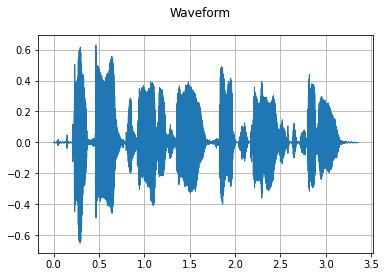

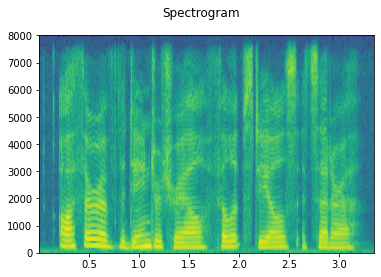

In [115]:
import torchaudio

SAMPLE_WAV_SPEECH_PATH = "./Dataset/wav/female/arctic_a0001.wav"


waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)
print(np.shape(waveform))
plt.clf()
print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram_from_wave(waveform, sample_rate)
#play_audio(waveform, sample_rate)

In [116]:
def plot_specgram(spec, sample_rate, title="Spectrogram", xlim=None):
  num_freq, num_frames, num_channels = spec.shape
  time_axis = np.arange(0, num_frames) / sample_rate
  freq_axis = np.arange(0, num_freq) * sample_rate/2/num_freq
  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].pcolormesh(time_axis, freq_axis, spec[:,:,c], cmap='viridis')
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

C:\Users\admin\miniconda3\envs\VAE-Speech\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


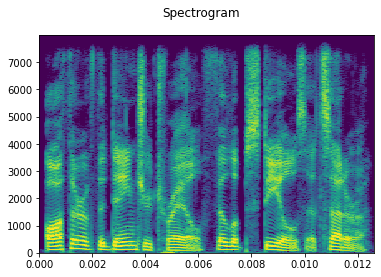

In [117]:
data = np.load('./Dataset/array/male.npy', allow_pickle=True)

data[0].shape

plot_specgram(data[0], sample_rate)
